In [68]:
import matplotlib.pyplot as plt

import re

import pandas as pd

import numpy as np

pd.options.display.max_columns = 30

from numpy import *

import plotly.express as px

import plotly.io as pio

import seaborn as sns

pio.renderers.default = "plotly_mimetype+notebook" #notebook renderer needed in order to show plotly graphs in 
                                                   #html output and plotly renderer needed to show them properly 
                                                   #in Jupyterlab



Background and Project Description:

In this project I analyse both the frequency/count and proportions of the time each letter shows up in three different documents I previously wrote - an essay, a resume, and a lab report.  I read in the text data and use Python to determine the letter counts and proportions and store the information in dataframes.  The goal of the analysis is to determine what differences, if any, there are in the letter frequencies of the three different types of documents.

                                  Open Documents and save contents as string variables

In [ ]:
EssayFileName = "Vaccines are Beneficial.txt"

ResumeFileName = "Resume.txt"

LabFileName = "EEE 334 Lab 1.txt"


EssayLines = ""

Resumelines = ""

LabLines = ""


def Read(FileName, lines):
    with open(FileName, "r", encoding = 'utf-8') as File:
        lines = File.read()
    return(lines)
    
EssayText = Read(EssayFileName, EssayLines)

ResumeText = Read(ResumeFileName, Resumelines)

LabText = Read(LabFileName, LabLines)

    

                                                Clean and Sort Data

In [ ]:
def CleanData(Text):
    Text = re.sub(r'[^a-zA-Z]', '', Text)
    
    Text = Text.lower()
    
    return(Text)

EssayText = CleanData(EssayText)

ResumeText = CleanData(ResumeText)

LabText = CleanData(LabText) 

I removed all non-alphabetic characters and changed all uppercase letters to lowercase.  That ensures I can obtain the frequency of just the letters and that all instances of the same letter will counted without regard to case.

                                        Get Letter Frequencies as Dictionaries 

In [19]:
def GetFrequencies(Text):  
    LetterFrequencies = {}
    for keys in Text:
        LetterFrequencies[keys] = LetterFrequencies.get(keys, 0) + 1
    return(LetterFrequencies)

EssayFrequencyDict = GetFrequencies(EssayText)

ResumeFrequencyDict = GetFrequencies(ResumeText)

LabFrequencyDict = GetFrequencies(LabText)

                                Convert Dictionaries to Data Frames and Sort Frequency by Letter

In [21]:
def ConvertAndSort(FrequencyDict, column2):
    Frequency_df = pd.DataFrame(FrequencyDict.items(), columns=['Letter', column2]) 

    Frequency_df = Frequency_df.sort_values("Letter")

    Frequency_df = Frequency_df[Frequency_df.Letter != " "].reset_index()  #renumber rows from 0 to 1 from the top down
    
    Frequency_df.pop('index')  #remove column containing prior order as I have no need of it
    
    Frequency_df.dropna(inplace = True) 
    
    return(Frequency_df)
    
EssayFrequency_df = ConvertAndSort(EssayFrequencyDict, 'Essay Frequency')

ResumeFrequency_df = ConvertAndSort(ResumeFrequencyDict, 'Resume Frequency')

LabFrequency_df = ConvertAndSort(LabFrequencyDict, 'Lab Frequency')

EssayFrequency_df.head()

,Letter,Essay Frequency
0,a,1223
1,b,163
2,c,650
3,d,503
4,e,1901


                                            Merge Dataframes and Get Frequency Proportions

Since the data was sorted by letter in the previous step, each frequency category doesn't need its own separate letter category, hence, I drop that column from the resume and lab df's, keeping it on the essay df, and then concantenate them.

In [25]:
#"Letter" column in each df is the same, so two of them are being concantenated without it
temp = pd.concat([EssayFrequency_df, ResumeFrequency_df.drop(['Letter'], axis = 1, inplace = False)], axis = 1, join = 'outer')

merged_data = pd.concat([temp, LabFrequency_df.drop(['Letter'], axis = 1, inplace = False)], axis = 1, join = 'outer')

merged_data.dropna(inplace = True)

merged_data.columns = ["Letter", "Essay", "Resume", "Lab Report"]

print(merged_data.head())

frequency_proportions = merged_data.copy() #copies VALUE of variable rather than the reference

temp = frequency_proportions.iloc[:, 1:4]

frequency_proportions.iloc[:, 1:4] = temp/sum(temp)

frequency_proportions.columns = ["Letter", "Essay", "Resume", "Lab Report"]

frequency_proportions.head()

  Letter  Essay  Resume  Lab Report
0      a   1223     233         996
1      b    163      37         187
2      c    650     185         448
3      d    503     108         448
4      e   1901     300        1471


,Letter,Essay,Resume,Lab Report
0,a,0.088610,0.081241,0.079878
1,b,0.011810,0.012901,0.014997
2,c,0.047095,0.064505,0.035929
3,d,0.036444,0.037657,0.035929
4,e,0.137734,0.104603,0.117973


Of note here is that, while the counts are quite different, the proportion for a given letter is similar in each document type.

                                                         Get Summary Stats

In [24]:
SummaryStats = (merged_data.describe()).round(decimals = 2)

SummaryStats_Proportions = (frequency_proportions.describe()).round(decimals = 3)

def MergeStats(df1, df2, Axis, key1, key2): #axis = 1 means join by column and axis = 0 means join by row    
    summary_stats = pd.concat([df1, df2], axis = Axis, join = 'outer', 
                              keys = [key1, key2])
    try:
        return summary_stats.drop('count')    
    except:
        return summary_stats
    
summary_stats = MergeStats(SummaryStats, SummaryStats_Proportions, 1, 'Letter Counts', ' Letter Proportions')

summary_stats

Letter Counts                     Letter Proportions                  
             Essay  Resume Lab Report               Essay Resume Lab Report
mean        530.85  110.31     479.58               0.038  0.038      0.038
std         477.23   95.49     392.42               0.035  0.033      0.031
min           7.00    5.00      14.00               0.001  0.002      0.001
25%         189.00   27.25     197.00               0.014  0.010      0.016
50%         332.00   93.00     375.00               0.024  0.032      0.030
75%         864.25  185.00     810.75               0.063  0.065      0.065
max        1901.00  300.00    1471.00               0.138  0.105      0.118

What's noteworthy here is that, not only are the statistics for each document type very similar in the proportions category (which is expected based on the similarity in the proportions in the previous section), but that the standard deviations are so small.  I would have expected more variation, as I assumed that some letters are used much more frequently than others.  While that does appear to be the case, as the minimum proportion is only 0.001 for the essay and lab report and 0.002 for the resume, and the maximum proportions are 0.138, 0.105, and 0.118, which is a not insignificant difference, it's much smaller than I would have expected.   

                                               Summary Stats by Letter

In [26]:
#easiest way to get stats for data grouped by letter is to make the letters index names and transpose the df.  
#When I used the groupby function instead, .describe gave weird results.

def SummaryStatsByLetter(df):
    df.index = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 
                'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

    GroupDFByLetter = df.drop('Letter', axis = 1)

    GroupDFByLetter = GroupDFByLetter.transpose()

    SummaryStatsByLetter = (GroupDFByLetter.describe()).round(decimals = 4)

    return SummaryStatsByLetter.drop('count')

LetterStats = MergeStats(SummaryStatsByLetter(merged_data), SummaryStatsByLetter(frequency_proportions), Axis = 0, 
                        key1 = 'Count', key2 = "Proportion")
LetterStats

a         b         c         d          e         f  \
Count      mean   817.3333  129.0000  427.6667  353.0000  1224.0000  213.6667   
           std    518.6196   80.5729  233.1659  213.9509   828.5874  155.6610   
           min    233.0000   37.0000  185.0000  108.0000   300.0000   34.0000   
           25%    614.5000  100.0000  316.5000  278.0000   885.5000  166.5000   
           50%    996.0000  163.0000  448.0000  448.0000  1471.0000  299.0000   
           75%   1109.5000  175.0000  549.0000  475.5000  1686.0000  303.5000   
           max   1223.0000  187.0000  650.0000  503.0000  1901.0000  308.0000   
Proportion mean     0.0832    0.0132    0.0492    0.0367     0.1201    0.0194   
           std      0.0047    0.0016    0.0144    0.0009     0.0167    0.0066   
           min      0.0799    0.0118    0.0359    0.0359     0.1046    0.0119   
           25%      0.0806    0.0124    0.0415    0.0362     0.1113    0.0171   
           50%      0.0812    0.0129    0.0471    0.0364     0.1180    0.0223   
           75%      0.0849    0.0139    0.0558    0.0371     0.1279    0.0231   
           max      0.0886    0.0150    0.0645    0.0377     0.1377    0.0240   

                        g         h         i        j        k         l  \
Count      mean  180.3333  402.0000  740.6667  13.0000  54.6667  439.3333   
           std    80.3886  298.8327  384.5326   5.0000  44.0946  278.0905   
           min    90.0000   62.0000  298.0000   8.0000   9.0000  121.0000   
           25%   148.5000  291.5000  615.0000  10.5000  33.5000  341.5000   
           50%   207.0000  521.0000  932.0000  13.0000  58.0000  562.0000   
           75%   225.5000  572.0000  962.0000  15.5000  77.5000  598.5000   
           max   244.0000  623.0000  992.0000  18.0000  97.0000  635.0000   
Proportion mean    0.0220    0.0362    0.0835   0.0022   0.0050    0.0446   
           std     0.0085    0.0127    0.0177   0.0021   0.0024    0.0055   
           min     0.0150    0.0216    0.0719   0.0006   0.0031    0.0407   
           25%     0.0173    0.0317    0.0733   0.0010   0.0037    0.0415   
           50%     0.0196    0.0418    0.0747   0.0014   0.0042    0.0422   
           75%     0.0255    0.0435    0.0893   0.0030   0.0060    0.0466   
           max     0.0314    0.0451    0.1039   0.0045   0.0078    0.0509   

                        m          n         o         p        q         r  \
Count      mean  247.0000   658.0000  638.0000  212.3333  14.6667  585.0000   
           std   131.2745   415.1975  431.9479  120.8153  15.0444  351.7400   
           min    96.0000   213.0000  140.0000   73.0000   5.0000  185.0000   
           25%   203.5000   469.5000  501.5000  174.5000   6.0000  454.5000   
           50%   311.0000   726.0000  863.0000  276.0000   7.0000  724.0000   
           75%   322.5000   880.5000  887.0000  282.0000  19.5000  785.0000   
           max   334.0000  1035.0000  911.0000  288.0000  32.0000  846.0000   
Proportion mean    0.0275     0.0692    0.0613    0.0228   0.0016    0.0616   
           std     0.0052     0.0095    0.0110    0.0024   0.0010    0.0081   
           min     0.0242     0.0582    0.0488    0.0209   0.0005    0.0525   
           25%     0.0246     0.0662    0.0574    0.0215   0.0011    0.0585   
           50%     0.0249     0.0743    0.0660    0.0221   0.0017    0.0645   
           75%     0.0292     0.0746    0.0676    0.0238   0.0022    0.0662   
           max     0.0335     0.0750    0.0692    0.0255   0.0026    0.0678   

                        s          t         u         v         w        x  \
Count      mean  667.3333   885.3333  289.3333  195.6667  145.0000  22.3333   
           std   391.8014   554.3910  173.6097  153.0240  106.2262  18.5831   
           min   219.0000   248.0000   99.0000   20.0000   25.0000   7.0000   
           25%   529.0000   700.0000  214.5000  143.5000  104.0000  12.0000   
           50%   839.0000  1152.0000  330.0000  267.0000  183.0000  17.0

It's harder to analyze these statistics simply because there are far more of them, but what does seem noteworthy is that, despite the different grouping the standard deviations in the proportions category remain quite small -- the largest one is 0.0177 for the letter i.
Something to keep in mind with this grouping of the data though, is that there are only three total data values for each letter, since there are only three documents included in this analysis.  It's possible that a larger sample of texts would result in significantly larger deviations.  

                                              Reshape data to plot properly

In [44]:
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 
            'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r',
            's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

def ReshapeData(df, value_name):
    data_by_document = df.copy()
    
    data_by_document.index = alphabet
    
    data_by_document = data_by_document.transpose().drop('Letter').reset_index()

    data_by_document.rename(columns = {'index' : 'Document Type'}, inplace = True)

    data_by_document = data_by_document.melt(id_vars = ["Document Type"], var_name = "Letter", value_name = value_name)

    return data_by_document


frequencies_by_document = ReshapeData(merged_data, 'Count')
Proportions_by_document = ReshapeData(frequency_proportions, 'Proportion')

print(frequencies_by_document.head())
Proportions_by_document.head()

  Document Type Letter Count
0         Essay      a  1223
1        Resume      a   233
2    Lab Report      a   996
3         Essay      b   163
4        Resume      b    37


,Document Type,Letter,Proportion
0,Essay,a,0.08861
1,Resume,a,0.081241
2,Lab Report,a,0.079878
3,Essay,b,0.01181
4,Resume,b,0.012901


What I did here was to melt the dataframes such that document type is a single category.  That allows me to use it as a grouping variable when plotting the data. 

                                                Boxplots by Document Type

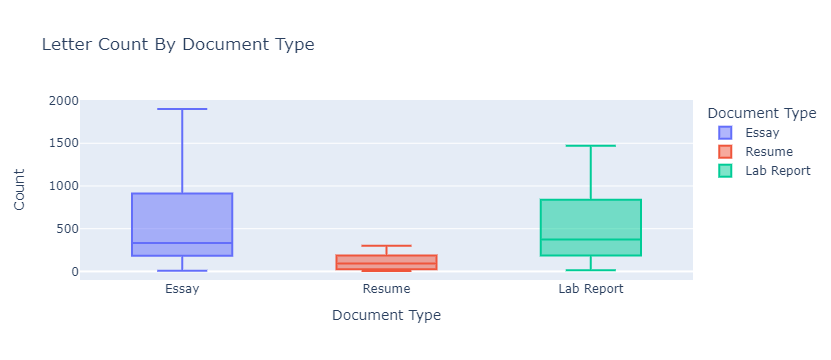

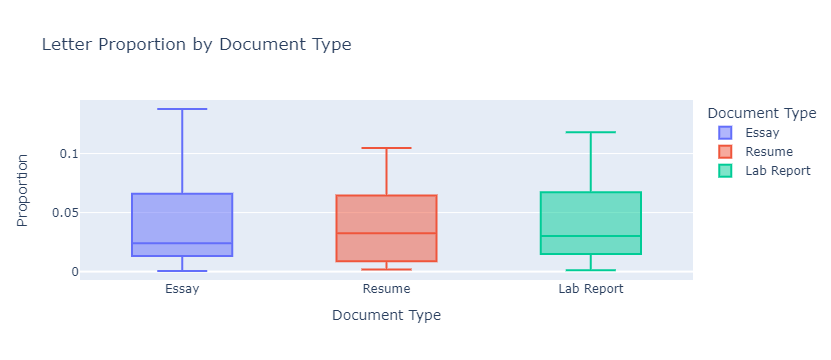

In [48]:
px.box(frequencies_by_document, y = 'Count', x = 'Document Type', color = 'Document Type', 
       title = "Letter Count By Document Type").show()

px.box(Proportions_by_document, y = 'Proportion', x = 'Document Type', color = 'Document Type',
      title = 'Letter Proportion by Document Type').show()

Looking at the plots for letter count, what immediately stands out is that both the range and the IQR for the resume are small much smaller than for the other two documents.  That makes sense since the resume is the shortest of the three documents.  Looking at the plot for the proportions though, this difference all but disapears, suggesting that there isn't a significant difference in the letter proportions between the three document types.

                                             Boxplots by Letter

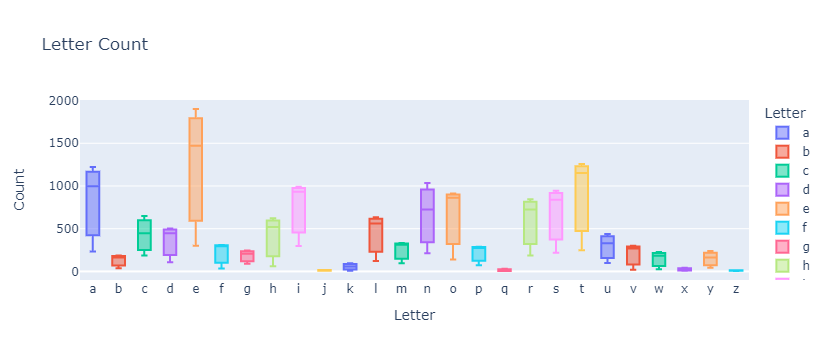

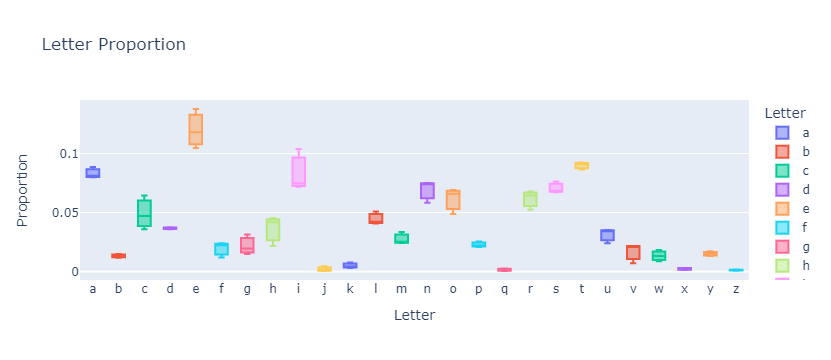

In [53]:
px.box(frequencies_by_document, y = 'Count', x = 'Letter', color = 'Letter', 
       title = "Letter Count").show()

px.box(Proportions_by_document, y = 'Proportion', x = 'Letter', color = 'Letter',
      title = 'Letter Proportion').show()

Here, more so than with the summary statistics, we can get a better picture of the variation in both the counts and proportions of the different letters.  We can see from the y axis of the plot for proportion that the data doesn't range much higher than 0.1, and yet, within that range, the differences are much clearer than with the numbers.  For example, e ranges from about 0.1 to 0.13 while k ranges from about 0.003 to 0.008.  Both are pretty small ranges, but the latter is much smaller and would be far to the left of the former were they plotted on a horizontal number line.

                                                 Bar Graphs

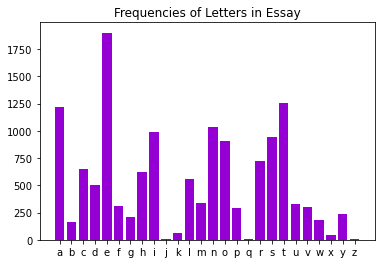

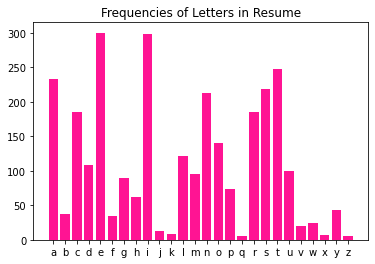

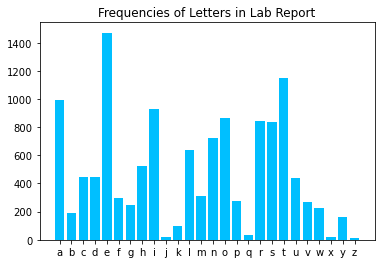

In [56]:
%matplotlib inline

def BarGraph(df, Title, Color, Y):
    plt.bar(x = df['Letter'], height = df[Y], color = Color)
    plt.title(Title)
    plt.show()

BarGraph(EssayFrequency_df, "Frequencies of Letters in Essay", "darkviolet", 'Essay Frequency')

BarGraph(ResumeFrequency_df, "Frequencies of Letters in Resume", "deeppink", 'Resume Frequency')

BarGraph(LabFrequency_df, "Frequencies of Letters in Lab Report", "deepskyblue", 'Lab Frequency')


                                                 Histograms

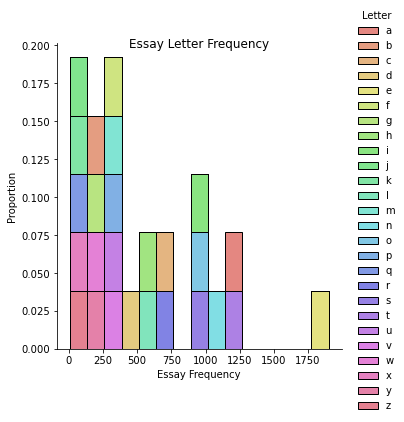

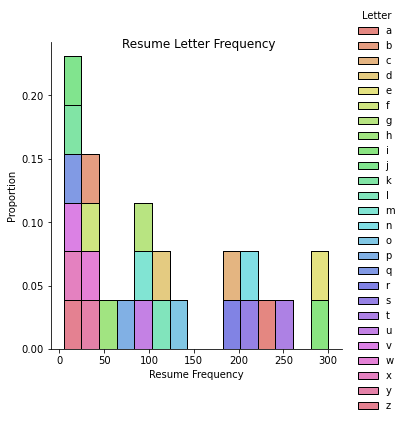

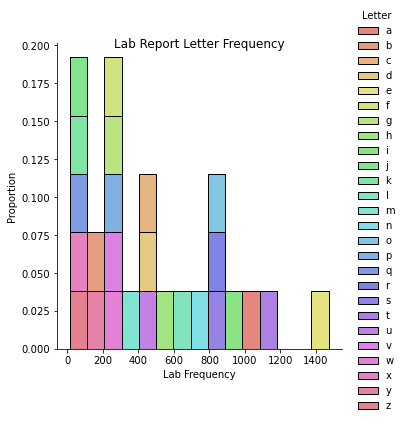

In [65]:
%matplotlib inline

sns.set_palette("hls", 26)

def histogram(df, Title, X):
    hist = sns.displot(df, x = X, bins = 15, hue = 'Letter', multiple = 'stack', stat = 'proportion')
    hist.fig.suptitle(Title)
    
histogram(EssayFrequency_df, "Essay Letter Frequency", 'Essay Frequency')
histogram(ResumeFrequency_df, "Resume Letter Frequency", 'Resume Frequency')
histogram(LabFrequency_df, "Lab Report Letter Frequency", 'Lab Frequency')


Overall, the distributions look fairly similar, though there are some notable differences, such as the gap in the middle of the histogram for the resume and the one on the right of the histogram for the essay.  But a visual inspection can only do so much, so the following section will use the KS hypothesis test to perform a more quantitative comparision.  


                                                 KS Tests:

In [83]:
from scipy.stats import ks_2samp as ks_test


In [82]:
result = ks_test(EssayFrequency_df['Essay Frequency'], ResumeFrequency_df['Resume Frequency'])

result = pd.DataFrame(result)
result.index = ["Test Statistic", "P Value"]
result.columns = ["Essay vs Resume"]
result

,Essay vs Resume
Test Statistic,0.576923
P Value,0.000244


In [84]:
result = ks_test(EssayFrequency_df['Essay Frequency'], LabFrequency_df['Lab Frequency'])

result = pd.DataFrame(result)
result.index = ["Test Statistic", "P Value"]
result.columns = ["Essay vs Lab Report"]
result

,Essay vs Lab Report
Test Statistic,0.115385
P Value,0.996583


In [86]:
result = ks_test(ResumeFrequency_df['Resume Frequency'], LabFrequency_df['Lab Frequency'])

result = pd.DataFrame(result)
result.index = ["Test Statistic", "P Value"]
result.columns = ["Resume vs Lab Report"]
result

,Resume vs Lab Report
Test Statistic,0.576923
P Value,0.000244


Looking at the results of the hypothesis testing, the p values for the comparision between the resume and both eother documents are very small, which looks like strong evidence that there's a real difference in those distributions that isn't due just to random chance.  On the other hand, the p value for the comparision between the essay data and lab report data is very nearly 1, which provides pretty much zero evidence that there's a real difference between those distributions; or, to be more specific, it means the differences could VERY easily have occurred just due to random chance.  